In [3]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
#Load the dataset
df = pd.read_csv("final_trial.csv")

In [5]:
# preprocess the text
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

df['clean_text'] = df['Poem'].apply(preprocess)

#Split the poem column into individual stanzas
df['stanzas'] = df['Poem'].apply(sent_tokenize)


In [6]:
#Convert emotions column to numerical labels
emotions = ['love', 'sad', 'anger', 'hate', 'fear', 'surprise', 'courage', 'joy', 'peace', 'hope', 'care']
label_encoder = LabelEncoder()
df['emotion_label'] = label_encoder.fit_transform(df['Emotion'])

In [7]:
#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['stanzas'], df['emotion_label'], test_size=0.2, random_state=42)

#Tokenize the stanzas
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

#Pad the tokenized sequences
max_length = max([len(tokens) for tokens in X_train_tokens])
X_train_padded = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

In [8]:
#Build the CNN-BiLSTM model
embedding_dim = 100

model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train the model
model.fit(X_train_padded, y_train, epochs=20, batch_size=32)

Epoch 1/20
125/125 [==============================] - 5s 19ms/step - loss: 2.1899 - accuracy: 0.1814
Epoch 2/20
125/125 [==============================] - 2s 19ms/step - loss: 2.1376 - accuracy: 0.2022
Epoch 3/20
125/125 [==============================] - 2s 19ms/step - loss: 1.7184 - accuracy: 0.3886
Epoch 4/20
125/125 [==============================] - 2s 18ms/step - loss: 1.1708 - accuracy: 0.6116
Epoch 5/20
125/125 [==============================] - 2s 18ms/step - loss: 0.7493 - accuracy: 0.7464
Epoch 6/20
125/125 [==============================] - 2s 18ms/step - loss: 0.4616 - accuracy: 0.8574
Epoch 7/20
125/125 [==============================] - 2s 18ms/step - loss: 0.3351 - accuracy: 0.8877
Epoch 8/20
125/125 [==============================] - 2s 19ms/step - loss: 0.2566 - accuracy: 0.9156
Epoch 9/20
125/125 [==============================] - 2s 18ms/step - loss: 0.2066 - accuracy: 0.9318
Epoch 10/20
125/125 [==============================] - 2s 18ms/step - loss: 0.1784 - accura

In [9]:
#Extract features using the trained model
feature_extractor = Sequential(model.layers[:6])
X_train_features = feature_extractor.predict(X_train_padded)
X_test_features = feature_extractor.predict(X_test_padded)

In [10]:
#Train the PassiveAggressiveClassifier on extracted features
classifier = PassiveAggressiveClassifier(random_state=42, max_iter=100)
classifier.fit(X_train_features, y_train)

PassiveAggressiveClassifier(max_iter=100, random_state=42)

In [11]:
#Evaluate the performance of the classifier
y_pred = classifier.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy * 100, "%")

Accuracy: 21.64328657314629 %


In [12]:
#Use the trained model to predict the emotion of each stanza in a new poem
new_poem = """
Weavers, weaving at break of day,
Why do you weave a garment so gay?
Blue as the wing of a halcyon wild,
We weave the robes of a new-born child.

Weavers, weaving at fall of night,
Why do you weave a garment so bright?
Like the plumes of a peacock, purple and green,
We weave the marriage-veils of a queen.

Weavers, weaving solemn and still,
What do you weave in the moonlight chill? 
White as a feather and white as a cloud,
We weave a dead man's funeral shroud.
"""
new_stanzas = sent_tokenize(new_poem)
new_stanzas_tokens = tokenizer.texts_to_sequences(new_stanzas)
new_stanzas_padded = pad_sequences(new_stanzas_tokens, maxlen=max_length, padding='post')
new_stanzas_features = feature_extractor.predict(new_stanzas_padded)
new_stanzas_emotions = classifier.predict(new_stanzas_features)
new_stanzas_emotions = label_encoder.inverse_transform(new_stanzas_emotions)

for stanza, emotion in zip(new_stanzas, new_stanzas_emotions):
    print('Stanza:', stanza.strip())
    print('Emotion:', emotion)
    print("\n")

Stanza: Weavers, weaving at break of day,
Why do you weave a garment so gay?
Emotion: love


Stanza: Blue as the wing of a halcyon wild,
We weave the robes of a new-born child.
Emotion: sad


Stanza: Weavers, weaving at fall of night,
Why do you weave a garment so bright?
Emotion: courage


Stanza: Like the plumes of a peacock, purple and green,
We weave the marriage-veils of a queen.
Emotion: sad


Stanza: Weavers, weaving solemn and still,
What do you weave in the moonlight chill?
Emotion: love


Stanza: White as a feather and white as a cloud,
We weave a dead man's funeral shroud.
Emotion: sad




In [52]:
# Save the model
model.save("ml_dl_model.h5")

In [16]:
import pandas as pd

# Create a DataFrame for the extracted features
train_features_df = pd.DataFrame(X_train_features)
test_features_df = pd.DataFrame(X_test_features)

# Save the features to CSV files
train_features_df.to_csv("train_features.csv", index=False)
test_features_df.to_csv("test_features.csv", index=False)


In [ ]:
import matplotlib.pyplot as plt

# Count the frequency of words for each emotion label
word_counts = {emotion: {} for emotion in emotions}

for stanzas, emotion_idx in zip(X_train, y_train):
    emotion = label_encoder.inverse_transform([emotion_idx])[0]
    for stanza in stanzas:
        for word in stanza.split():
            if word not in word_counts[emotion]:
                word_counts[emotion][word] = 1
            else:
                word_counts[emotion][word] += 1

# Plot the word frequencies for each emotion label
fig, axes = plt.subplots(nrows=len(emotions), figsize=(10, 8))

for i, emotion in enumerate(emotions):
    words = list(word_counts[emotion].keys())
    counts = list(word_counts[emotion].values())
    ax = axes[i]
    ax.bar(words, counts)
    ax.set_title(emotion)
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


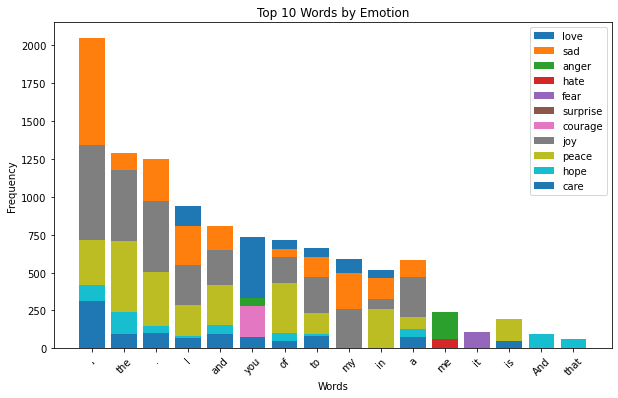

AttributeError: 'TransposedFont' object has no attribute 'getbbox'

In [42]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk

# Load the dataset
df = pd.read_csv("final_trial.csv")

# Preprocess the text
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

df['clean_text'] = df['Poem'].apply(preprocess)

# Convert emotions column to numerical labels
emotions = ['love', 'sad', 'anger', 'hate', 'fear', 'surprise', 'courage', 'joy', 'peace', 'hope', 'care']
label_encoder = LabelEncoder()
df['emotion_label'] = label_encoder.fit_transform(df['Emotion'])

# Calculate word frequencies for each emotion label
word_frequencies = {}
for emotion in emotions:
    # Get stanzas for the current emotion
    stanzas = df[df['Emotion'] == emotion]['Poem']
    # Concatenate all stanzas into a single string
    text = ' '.join(stanzas)
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Calculate word frequencies
    frequencies = nltk.FreqDist(tokens)
    # Store the word frequencies for the current emotion
    word_frequencies[emotion] = frequencies

# Plot word frequencies for each emotion
plt.figure(figsize=(10, 6))
for emotion in emotions:
    frequencies = word_frequencies[emotion]
    common_words = frequencies.most_common(10)  # Get top 10 most common words
    words, counts = zip(*common_words)
    plt.bar(words, counts, label=emotion)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words by Emotion')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Generate and display word clouds for each emotion
for emotion in emotions:
    text = ' '.join(df[df['Emotion'] == emotion]['clean_text'])
    wordcloud = WordCloud(collocations=False).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(emotion)
    plt.axis('off')
    plt.show()


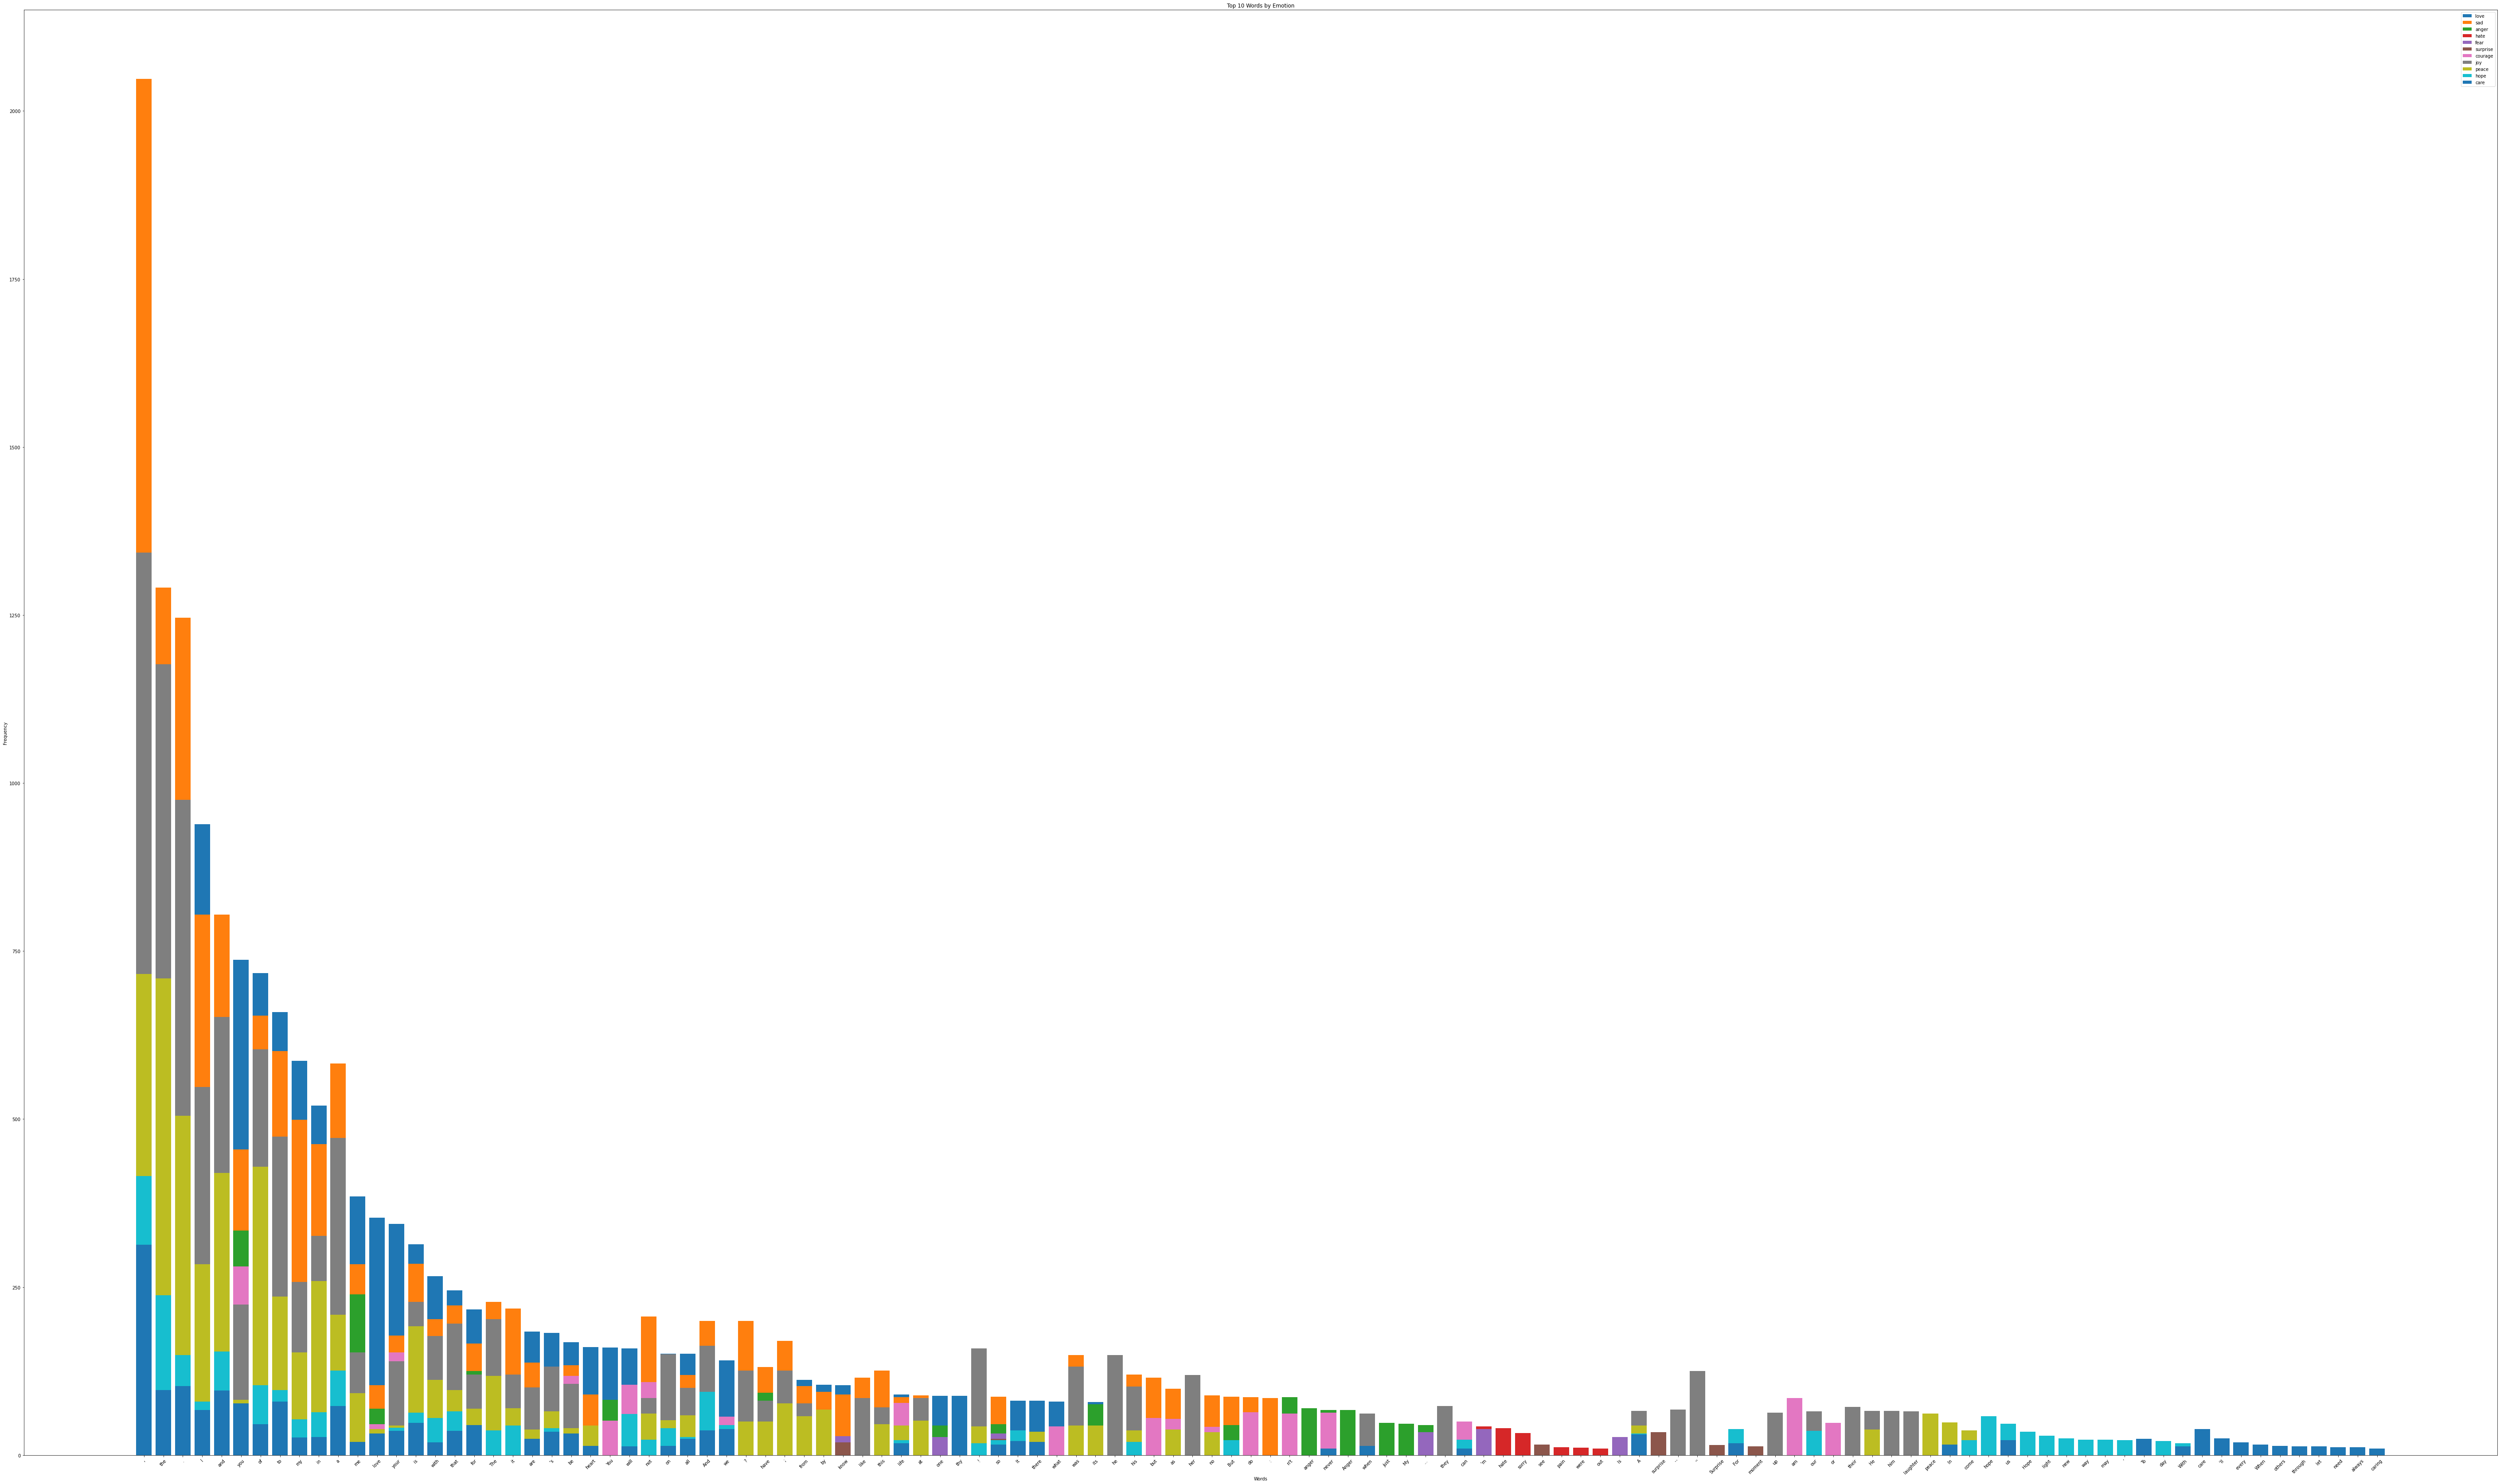

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk

# Load the dataset
df = pd.read_csv("final_trial.csv")

# Preprocess the text
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

df['clean_text'] = df['Poem'].apply(preprocess)

# Convert emotions column to numerical labels
emotions = ['love', 'sad', 'anger', 'hate', 'fear', 'surprise', 'courage', 'joy', 'peace', 'hope', 'care']
label_encoder = LabelEncoder()
df['emotion_label'] = label_encoder.fit_transform(df['Emotion'])

# Calculate word frequencies for each emotion label
word_frequencies = {}
for emotion in emotions:
    # Get stanzas for the current emotion
    stanzas = df[df['Emotion'] == emotion]['Poem']
    # Concatenate all stanzas into a single string
    text = ' '.join(stanzas)
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Calculate word frequencies
    frequencies = nltk.FreqDist(tokens)
    # Store the word frequencies for the current emotion
    word_frequencies[emotion] = frequencies

# Plot word frequencies for each emotion
plt.figure(figsize=(100, 60))
for emotion in emotions:
    frequencies = word_frequencies[emotion]
    common_words = frequencies.most_common(50)  # Get top 50 most common words
    words, counts = zip(*common_words)
    plt.bar(words, counts, label=emotion)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words by Emotion')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [2]:
!pip install wordcloud

In [60]:
# Access the word frequencies for the "love" emotion
love_frequencies = word_frequencies['sad']

# Get the most common words associated with "love"
most_common_words = love_frequencies.most_common(100)

# Extract the words
love_words = [word for word, count in most_common_words]

# Print the words
print("Words defining 'love' label:")
for word in love_words:
    print(word)


Words defining 'love' label:
,
the
.
and
I
of
to
a
my
in
you
is
me
The
that
it
not
with
?
And
your
;
for
was
on
are
be
have
he
this
's
his
all
but
like
love
from
as
by
know
heart
her
no
at
so
But
do
life
:
will
My
their
eyes
am
!
can
n't
You
him
when
or
has
A
they
away
one
To
what
In
had
its
just
there
who
into
pain
Of
up
we
When
go
It
were
shall
she
”
thy
world
come
O
an
tears
never
our
day
We
could
night
He
only


In [59]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Access the word frequencies for the "love" emotion
love_frequencies = word_frequencies['love']

# Get the most common words associated with "love"
most_common_words = love_frequencies.most_common(100)

# Extract the words
love_words = [word for word, count in most_common_words]

# Generate a word cloud
wordcloud = WordCloud().generate(' '.join(love_words))

# Plot the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


AttributeError: 'TransposedFont' object has no attribute 'getbbox'